# 🧠 Brain Tumor Classification with ResNet50

**Production-Grade Transfer Learning Pipeline**

| Spec | Value |
|------|-------|
| Model | ResNet50 (ImageNet pretrained) |
| Classes | Glioma, Meningioma, Pituitary, No Tumor |
| Training | Two-Stage (Freeze → Fine-tune) |
| Server | 250GB RAM, RTX A6000 (48GB VRAM) |

---
## Step 0: Set Working Directory

In [2]:
# Change to the correct working directory
import os

TARGET_DIR = '/home/jovyan/work/cancer modele'

if os.path.exists(TARGET_DIR):
    os.chdir(TARGET_DIR)
    print(f"✅ Changed directory to: {os.getcwd()}")
else:
    print(f"⚠️ Directory not found: {TARGET_DIR}")
    print(f"   Current directory: {os.getcwd()}")

# Verify contents
print("\n" + "=" * 60)
print("📂 FOLDER CONTENTS:")
print("=" * 60)
for item in sorted(os.listdir('.')):
    if os.path.isdir(item):
        try:
            num_items = len(os.listdir(item))
            print(f"  📁 {item}/  ({num_items} items)")
        except:
            print(f"  📁 {item}/")
    else:
        size_kb = os.path.getsize(item) / 1024
        size_str = f"{size_kb/1024:.1f} MB" if size_kb > 1024 else f"{size_kb:.1f} KB"
        print(f"  📄 {item}  ({size_str})")

print("\n" + "=" * 60)
if os.path.exists('kaggle.json'):
    print("✅ kaggle.json FOUND - Ready to download dataset!")
else:
    print("❌ kaggle.json NOT FOUND - Please upload it to this folder!")

if os.path.exists('brain_tumor_dataset'):
    print("✅ brain_tumor_dataset/ FOUND - Dataset already downloaded!")
else:
    print("⏳ brain_tumor_dataset/ NOT FOUND - Will download from Kaggle.")

✅ Changed directory to: /home/jovyan/work/cancer modele

📂 FOLDER CONTENTS:
  📁 .ipynb_checkpoints/  (1 items)
  📄 Untitled.ipynb  (71.6 KB)
  📄 best_brain_tumor_model.keras  (164.7 MB)
  📄 brain-tumor-mri-dataset.zip  (148.6 MB)
  📁 brain_tumor_dataset/  (2 items)
  📄 kaggle.json  (0.1 KB)

✅ kaggle.json FOUND - Ready to download dataset!
✅ brain_tumor_dataset/ FOUND - Dataset already downloaded!


---
## Step 1: Environment Setup & GPU Configuration

In [3]:
# Install dependencies (NumPy <2.0 for TensorFlow compatibility)
!pip install -q "numpy<2.0" kaggle tensorflow pandas matplotlib seaborn scikit-learn

import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np

# Configure single GPU (avoid multi-GPU shared memory issues)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Use only the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        # Enable memory growth to avoid allocating all VRAM at once
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"✅ Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(f"⚠️ GPU config error: {e}")
else:
    print("⚠️ No GPU detected. Training will be slow on CPU.")

print(f"\n📦 NumPy Version: {np.__version__}")
print(f"📦 TensorFlow Version: {tf.__version__}")

# Show GPU info
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv

2025-12-21 18:17:25.710924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-21 18:17:25.847282: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-21 18:17:25.884361: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-21 18:17:26.609119: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

✅ Using GPU: /physical_device:GPU:0

📦 NumPy Version: 1.26.4
📦 TensorFlow Version: 2.10.1
name, memory.total [MiB], memory.free [MiB]
NVIDIA RTX A6000, 49140 MiB, 48666 MiB
NVIDIA RTX A6000, 49140 MiB, 48666 MiB


---
## Step 2: Import Libraries

In [4]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


---
## Step 3: Download Dataset from Kaggle

In [5]:
# Set Kaggle config directory to current folder
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

# Check for kaggle.json
if os.path.exists('kaggle.json'):
    os.chmod('kaggle.json', 0o600)  # Secure permissions
    print("✅ Kaggle API token found and secured.")
    
    # Download dataset if not already present
    if not os.path.exists('brain_tumor_dataset'):
        print("\n⬇️ Downloading Brain Tumor MRI Dataset...")
        !kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
        
        print("\n📂 Extracting...")
        !unzip -q brain-tumor-mri-dataset.zip -d brain_tumor_dataset
        print("✅ Dataset ready!")
    else:
        print("✅ Dataset already exists, skipping download.")
else:
    print("❌ ERROR: Please upload 'kaggle.json' to this folder first!")
    print("   Get it from: https://www.kaggle.com/settings → API → Create New Token")

# Verify dataset structure
TRAIN_DIR = 'brain_tumor_dataset/Training'
TEST_DIR = 'brain_tumor_dataset/Testing'

if os.path.exists(TRAIN_DIR):
    print("\n📊 Dataset Summary:")
    for split, path in [('Training', TRAIN_DIR), ('Testing', TEST_DIR)]:
        print(f"\n{split}:")
        for class_name in sorted(os.listdir(path)):
            class_path = os.path.join(path, class_name)
            if os.path.isdir(class_path):
                count = len(os.listdir(class_path))
                print(f"  - {class_name}: {count} images")

✅ Kaggle API token found and secured.
✅ Dataset already exists, skipping download.

📊 Dataset Summary:

Training:
  - glioma: 1321 images
  - meningioma: 1339 images
  - notumor: 1595 images
  - pituitary: 1457 images

Testing:
  - glioma: 300 images
  - meningioma: 306 images
  - notumor: 405 images
  - pituitary: 300 images


---
## Step 4: Load Data into RAM & Create Generators

In [6]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Training data generator WITH augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Test data generator WITHOUT augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Training Data (80%)
print("📥 Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED,
    shuffle=True
)

# Load Validation Data (20%)
print("\n📥 Loading Validation Data...")
val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED,
    shuffle=False
)

# Load Test Data
print("\n📥 Loading Test Data...")
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)

# Store class names for later
CLASS_NAMES = list(train_generator.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)

print(f"\n✅ Classes: {CLASS_NAMES}")
print(f"✅ Training samples: {train_generator.samples}")
print(f"✅ Validation samples: {val_generator.samples}")
print(f"✅ Test samples: {test_generator.samples}")

📥 Loading Training Data...
Found 4571 images belonging to 4 classes.

📥 Loading Validation Data...
Found 1141 images belonging to 4 classes.

📥 Loading Test Data...
Found 1311 images belonging to 4 classes.

✅ Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
✅ Training samples: 4571
✅ Validation samples: 1141
✅ Test samples: 1311


---
## Step 5: Build ResNet50 Model Architecture

In [7]:
def build_model(num_classes=4, freeze_backbone=True):
    """
    Build ResNet50 with custom classification head.
    
    Args:
        num_classes: Number of output classes
        freeze_backbone: If True, freeze all ResNet50 layers
    
    Returns:
        Compiled Keras model
    """
    # Load ResNet50 backbone (pretrained on ImageNet)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,  # Remove original classifier
        input_shape=(224, 224, 3)
    )
    
    # Freeze backbone if specified
    base_model.trainable = not freeze_backbone
    
    # Build custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dropout(0.5, name='dropout_1')(x)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = Dropout(0.3, name='dropout_2')(x)
    predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    # Create final model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model, base_model

# Build model with frozen backbone
model, base_model = build_model(num_classes=NUM_CLASSES, freeze_backbone=True)

# Count parameters
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print("🏗️ Model Architecture Summary:")
print(f"   Total Parameters: {total_params:,}")
print(f"   Trainable Parameters: {trainable_params:,}")
print(f"   Non-trainable Parameters: {non_trainable_params:,}")
print(f"\n   Backbone Layers: {len(base_model.layers)}")
print(f"   Backbone Frozen: {not base_model.trainable}")

2025-12-21 18:17:29.934170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-21 18:17:30.635539: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46698 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:4b:00.0, compute capability: 8.6


94765736/94765736 [==============================] - 3s 0us/step
🏗️ Model Architecture Summary:
   Total Parameters: 24,113,284
   Trainable Parameters: 525,572
   Non-trainable Parameters: 23,587,712

   Backbone Layers: 175
   Backbone Frozen: True


---
## Step 6: Define Training Callbacks

In [8]:
# EarlyStopping: Stop training if validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ModelCheckpoint: Save best model weights
checkpoint = ModelCheckpoint(
    'best_brain_tumor_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# ReduceLROnPlateau: Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

print("✅ Callbacks configured:")
print("   - EarlyStopping (patience=5, restore_best_weights=True)")
print("   - ModelCheckpoint (save best model to 'best_brain_tumor_model.keras')")
print("   - ReduceLROnPlateau (reduce LR by 0.5x if no improvement for 3 epochs)")

✅ Callbacks configured:
   - EarlyStopping (patience=5, restore_best_weights=True)
   - ModelCheckpoint (save best model to 'best_brain_tumor_model.keras')
   - ReduceLROnPlateau (reduce LR by 0.5x if no improvement for 3 epochs)


---
## Step 7: Stage 1 — Warm-up Training (Frozen Backbone) ❄️

In [9]:
print("🚀 STAGE 1: Training Custom Head (Backbone Frozen)")
print("=" * 50)

# Ensure backbone is frozen
base_model.trainable = False

# Compile with moderate learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train Stage 1
EPOCHS_STAGE1 = 10

history_stage1 = model.fit(
    train_generator,
    epochs=EPOCHS_STAGE1,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

print("\n✅ Stage 1 Complete!")
print(f"   Best Val Accuracy: {max(history_stage1.history['val_accuracy']):.4f}")

🚀 STAGE 1: Training Custom Head (Backbone Frozen)
Epoch 1/10


2025-12-21 18:17:39.803808: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8900


  1/143 [..............................] - ETA: 10:21 - loss: 1.8806 - accuracy: 0.1875

2025-12-21 18:17:41.050960: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


143/143 [==============================] - ETA: 0s - loss: 1.5926 - accuracy: 0.2975
Epoch 1: val_accuracy improved from -inf to 0.39264, saving model to best_brain_tumor_model.keras
143/143 [==============================] - 61s 400ms/step - loss: 1.5926 - accuracy: 0.2975 - val_loss: 1.2867 - val_accuracy: 0.3926 - lr: 1.0000e-04
Epoch 2/10
143/143 [==============================] - ETA: 0s - loss: 1.3999 - accuracy: 0.3640
Epoch 2: val_accuracy improved from 0.39264 to 0.40578, saving model to best_brain_tumor_model.keras
143/143 [==============================] - 56s 390ms/step - loss: 1.3999 - accuracy: 0.3640 - val_loss: 1.2515 - val_accuracy: 0.4058 - lr: 1.0000e-04
Epoch 3/10
143/143 [==============================] - ETA: 0s - loss: 1.2956 - accuracy: 0.4001
Epoch 3: val_accuracy improved from 0.40578 to 0.51709, saving model to best_brain_tumor_model.keras
143/143 [==============================] - 55s 383ms/step - loss: 1.2956 - accuracy: 0.4001 - val_loss: 1.2192 - val_accu

---
## Step 8: Stage 2 — Fine-tuning (Unfreeze Block 5) 🔥

In [10]:
print("🔥 STAGE 2: Fine-tuning (Unfreezing Top Layers)")
print("=" * 50)

# Unfreeze the last 20 layers (Block 5 of ResNet50)
base_model.trainable = True

# Keep first layers frozen, unfreeze only top layers
FREEZE_UNTIL = len(base_model.layers) - 20
for layer in base_model.layers[:FREEZE_UNTIL]:
    layer.trainable = False

# Count trainable params after unfreezing
trainable_now = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"\n📊 Trainable parameters after unfreezing: {trainable_now:,}")

# Re-compile with VERY LOW learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # 10x lower than Stage 1
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Reset callbacks for Stage 2
early_stop_stage2 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint_stage2 = ModelCheckpoint(
    'best_brain_tumor_model_finetuned.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train Stage 2
EPOCHS_STAGE2 = 20

history_stage2 = model.fit(
    train_generator,
    epochs=EPOCHS_STAGE2,
    validation_data=val_generator,
    callbacks=[early_stop_stage2, checkpoint_stage2, reduce_lr],
    verbose=1
)

print("\n✅ Stage 2 Complete!")
print(f"   Best Val Accuracy: {max(history_stage2.history['val_accuracy']):.4f}")

🔥 STAGE 2: Fine-tuning (Unfreezing Top Layers)

📊 Trainable parameters after unfreezing: 9,456,900
Epoch 1/20
143/143 [==============================] - ETA: 0s - loss: 2.2788 - accuracy: 0.4662
Epoch 1: val_accuracy improved from -inf to 0.27958, saving model to best_brain_tumor_model_finetuned.keras
143/143 [==============================] - 60s 396ms/step - loss: 2.2788 - accuracy: 0.4662 - val_loss: 1.8993 - val_accuracy: 0.2796 - lr: 1.0000e-05
Epoch 2/20
143/143 [==============================] - ETA: 0s - loss: 0.9886 - accuracy: 0.6097
Epoch 2: val_accuracy improved from 0.27958 to 0.34882, saving model to best_brain_tumor_model_finetuned.keras
143/143 [==============================] - 56s 389ms/step - loss: 0.9886 - accuracy: 0.6097 - val_loss: 1.3814 - val_accuracy: 0.3488 - lr: 1.0000e-05
Epoch 3/20
143/143 [==============================] - ETA: 0s - loss: 0.8074 - accuracy: 0.6653
Epoch 3: val_accuracy improved from 0.34882 to 0.61087, saving model to best_brain_tumor_mod

---
## Step 9: Training History Visualization

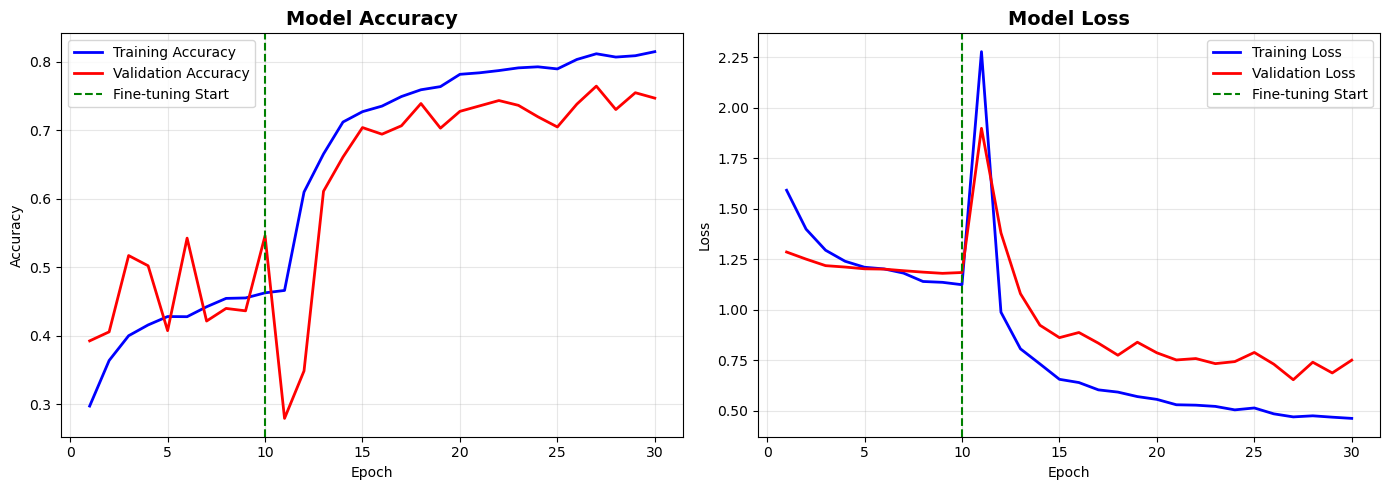


📊 Training history saved to 'training_history.png'


In [11]:
def plot_training_history(history1, history2):
    """Plot combined training history from both stages."""
    
    # Combine histories
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    stage1_end = len(history1.history['accuracy'])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    axes[0].plot(epochs, acc, 'b-', label='Training Accuracy', linewidth=2)
    axes[0].plot(epochs, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
    axes[0].axvline(x=stage1_end, color='green', linestyle='--', label='Fine-tuning Start')
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1].plot(epochs, loss, 'b-', label='Training Loss', linewidth=2)
    axes[1].plot(epochs, val_loss, 'r-', label='Validation Loss', linewidth=2)
    axes[1].axvline(x=stage1_end, color='green', linestyle='--', label='Fine-tuning Start')
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150)
    plt.show()
    print("\n📊 Training history saved to 'training_history.png'")

plot_training_history(history_stage1, history_stage2)

---
## Step 10: Model Evaluation on Test Set

In [12]:
print("📊 EVALUATING MODEL ON TEST SET")
print("=" * 50)

# Load best model
from tensorflow.keras.models import load_model

best_model_path = 'best_brain_tumor_model_finetuned.keras'
if os.path.exists(best_model_path):
    model = load_model(best_model_path)
    print(f"✅ Loaded best model from: {best_model_path}")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"\n🎯 Test Loss: {test_loss:.4f}")
print(f"🎯 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Generate predictions
print("\n⏳ Generating predictions...")
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Classification Report
print("\n" + "=" * 50)
print("📋 CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

📊 EVALUATING MODEL ON TEST SET
✅ Loaded best model from: best_brain_tumor_model_finetuned.keras

🎯 Test Loss: 0.5623
🎯 Test Accuracy: 0.7826 (78.26%)

⏳ Generating predictions...
41/41 [==============================] - 4s 77ms/step

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma     0.8197    0.6667    0.7353       300
  meningioma     0.6538    0.4444    0.5292       306
     notumor     0.8144    0.9753    0.8876       405
   pituitary     0.7888    0.9833    0.8754       300

    accuracy                         0.7826      1311
   macro avg     0.7692    0.7674    0.7569      1311
weighted avg     0.7723    0.7826    0.7663      1311




📊 CONFUSION MATRIX


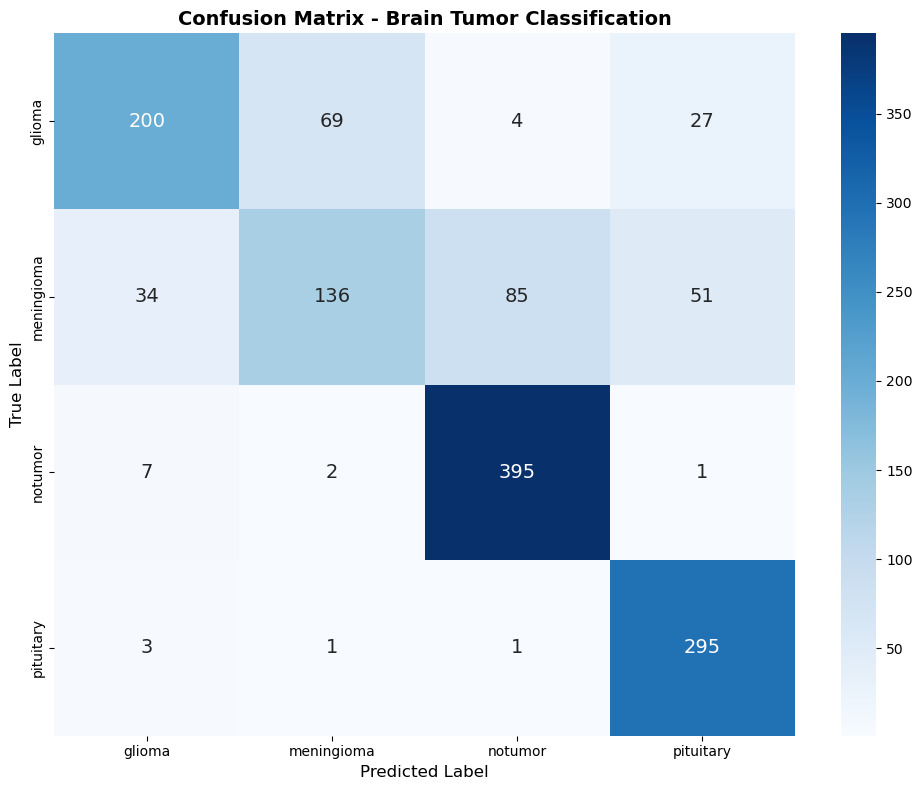


📊 Confusion matrix saved to 'confusion_matrix.png'


In [13]:
# Confusion Matrix Visualization
print("\n📊 CONFUSION MATRIX")
print("=" * 50)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    annot_kws={'size': 14}
)
plt.title('Confusion Matrix - Brain Tumor Classification', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

print("\n📊 Confusion matrix saved to 'confusion_matrix.png'")

---
## Step 11: Save Final Model

In [14]:
# Save final model
FINAL_MODEL_PATH = 'brain_tumor_resnet50_final.keras'
model.save(FINAL_MODEL_PATH)
print(f"\n✅ Final model saved to: {FINAL_MODEL_PATH}")

# Summary of saved files
print("\n" + "=" * 50)
print("📁 SAVED FILES SUMMARY")
print("=" * 50)
saved_files = [
    ('best_brain_tumor_model.keras', 'Best model from Stage 1'),
    ('best_brain_tumor_model_finetuned.keras', 'Best model from Stage 2 (Fine-tuned)'),
    ('brain_tumor_resnet50_final.keras', 'Final trained model'),
    ('training_history.png', 'Training curves visualization'),
    ('confusion_matrix.png', 'Confusion matrix heatmap')
]

for filename, description in saved_files:
    if os.path.exists(filename):
        size_mb = os.path.getsize(filename) / (1024 * 1024)
        print(f"  ✅ {filename} ({size_mb:.2f} MB) - {description}")
    else:
        print(f"  ❌ {filename} - Not found")

print("\n🎉 Training Complete!")


✅ Final model saved to: brain_tumor_resnet50_final.keras

📁 SAVED FILES SUMMARY
  ✅ best_brain_tumor_model.keras (96.51 MB) - Best model from Stage 1
  ✅ best_brain_tumor_model_finetuned.keras (164.70 MB) - Best model from Stage 2 (Fine-tuned)
  ✅ brain_tumor_resnet50_final.keras (164.70 MB) - Final trained model
  ✅ training_history.png (0.11 MB) - Training curves visualization
  ✅ confusion_matrix.png (0.07 MB) - Confusion matrix heatmap

🎉 Training Complete!


---
## 📊 Quick Inference Test

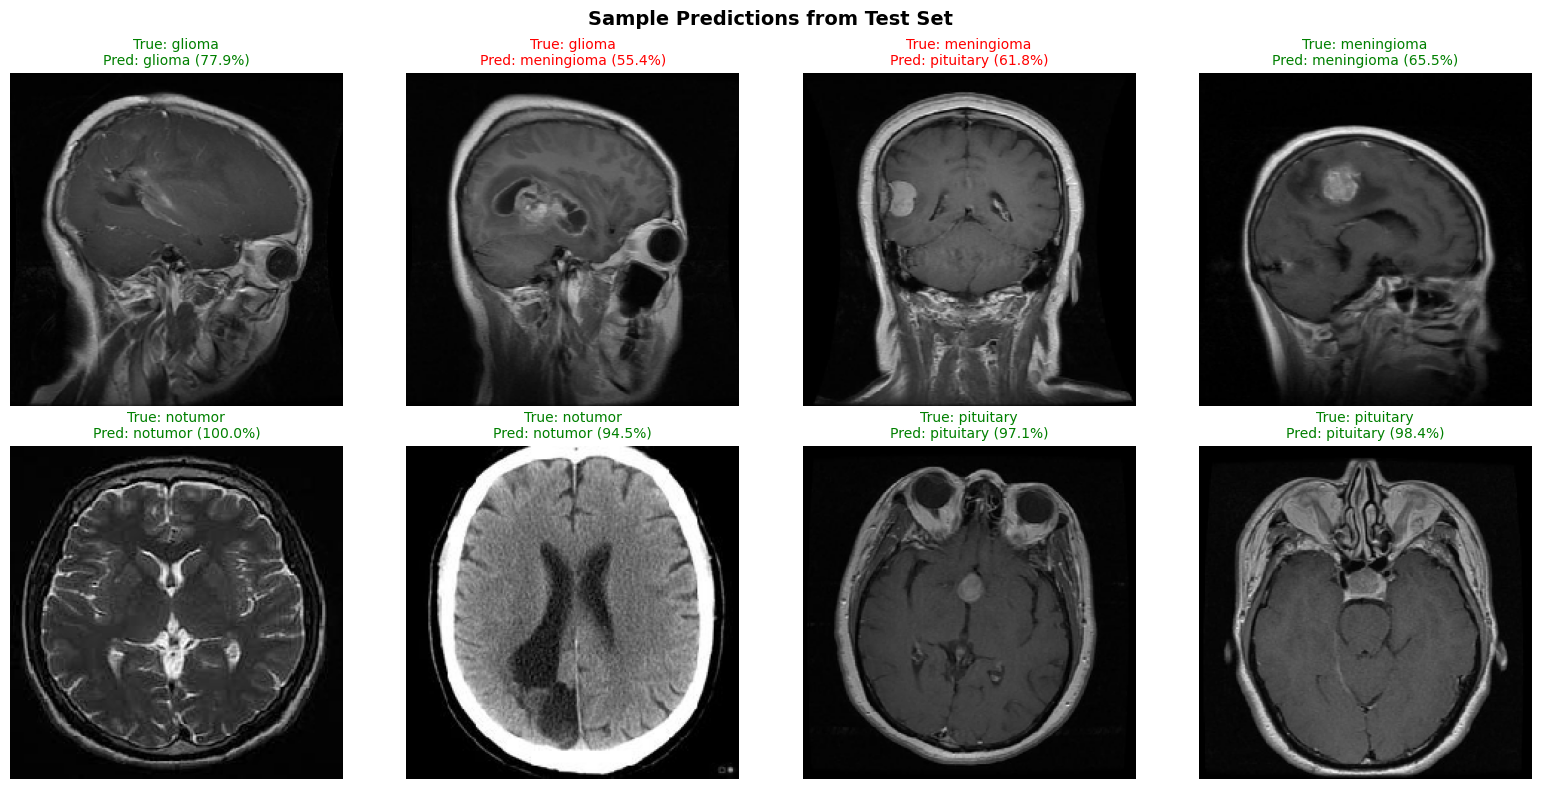

In [15]:
# Test on a few random images from test set
import random
from tensorflow.keras.preprocessing import image

def predict_single_image(img_path, model, class_names):
    """Predict class for a single image."""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    pred = model.predict(img_array, verbose=0)
    pred_class = class_names[np.argmax(pred)]
    confidence = np.max(pred) * 100
    
    return pred_class, confidence, img

# Get random test images
test_images = []
for class_name in CLASS_NAMES:
    class_dir = os.path.join(TEST_DIR, class_name)
    images = os.listdir(class_dir)[:2]  # Get 2 images per class
    for img_name in images:
        test_images.append((os.path.join(class_dir, img_name), class_name))

# Show predictions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, (img_path, true_label) in enumerate(test_images[:8]):
    pred_class, confidence, img = predict_single_image(img_path, model, CLASS_NAMES)
    
    axes[idx].imshow(img)
    color = 'green' if pred_class == true_label else 'red'
    axes[idx].set_title(f"True: {true_label}\nPred: {pred_class} ({confidence:.1f}%)", 
                        color=color, fontsize=10)
    axes[idx].axis('off')

plt.suptitle('Sample Predictions from Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150)
plt.show()